In [1]:
# # IMPORTS
# astronomy
from astropy.io import fits
# plotting 
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
# data 
import numpy as np
# my python files 
import match
import v2_AGN_DataAndPlotting as adp
import v2_SED as SED

# Read Data

In [2]:
def PrintNumber(myDict) :
    for key,val in myDict.items():
        if(isinstance(val,np.ndarray)):
            print(key,'\t',len(val)) 
        elif(isinstance(val,dict)):
            print(key,end='')
            for key1,val1 in val.items():
                print('\t',key1,'\t',len(val1))

In [3]:
# read AGN IDs
agnIDs = adp.ReadFile(adp.path_csv+'\\v2_AGNid_tricolor.csv')

# convert agnIDs into dict of integer numpy arrays 
agnIDs_dict = {
    'RED' : np.array(agnIDs[0], dtype=int),
    'GRN' : np.array(agnIDs[1], dtype=int),
    'BLU' : np.array(agnIDs[2], dtype=int)
}

# verify nmber of sources
PrintNumber(agnIDs_dict)

Cropped:  ['Row 1 = MIR exclusive AGN with id, redshift, and IRAC (n=464). Row 2 = MIR-X-ray inclusive AGN with id, redshift, and IRAC (n=671). Row 3 = X-ray exclusive AGN with id, redshift, and IRAC (n=1821). ']
RED 	 464
GRN 	 671
BLU 	 1821


In [4]:
# get redshifts
zDict = adp.ReadRedshifts(file=adp.path_cat+'\COSMOS_z_matches.csv')

Cropped:  ['ID', 'z']
Number of redshifts: 485793


In [5]:
agnInfo = {}
for key,val in agnIDs_dict.items():
    # match redshift to AGN
    key_zid, key_idz = match.match(zDict['ID'], val)
    agnInfo[key] = {
        'ID' : val[key_idz],
        'z'  : zDict['z'][key_zid]
    }
# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 464
	 z 	 464
GRN	 ID 	 671
	 z 	 671
BLU	 ID 	 1821
	 z 	 1821


In [6]:
# open COSMOS 2020 catalog file and get data 
with fits.open(adp.path_cat+'\\COSMOS2020_CLASSIC_R1_v2.0_master.fits') as hdul20:
    data20 = hdul20[1].data

# Prepare SEDs

In [7]:
# get starting info 
Fnu_uJy = SED.GetPhotometry(data20, print=False)#, fracErr=0.9999)
IDs_all = SED.GetID(data20, print=False)
lam_A   = SED.GetObservedWavelengths_A(print=False)

In [8]:
for key,val in agnInfo.items():
    # match photometry to AGN
    key_agn, key_phot = match.match(val['ID'], IDs_all)
    # get phot
    Fnu = Fnu_uJy[key_phot]
    # wavelengths
    lamR = SED.ConvertToRestWavelength(val['z'], print=False) # Rest
    lamO = np.array([SED.lam_A] * len(val['ID'])) # observed
    # get energy density and normalize
    lamFlam = SED.ConvertToEnergyDensity(lamO, Fnu, print=False)
    lamFlam_norm = SED.NormalizeSED_1um(lamR, lamFlam, print=False)
    # get luminosity at 1um
    lum1um = SED.Lum_at1um(lamFlam, lamR, val['z'], )
    # append info
    val['Rest Wavelength'] = lamR
    val['Energy Density'] = lamFlam
    val['Energy Density Normalized at 1um'] = lamFlam_norm
    val['Luminosity at 1um'] = lum1um

# verify number of sources
PrintNumber(agnInfo)

RED	 ID 	 464
	 z 	 464
	 Rest Wavelength 	 464
	 Energy Density 	 464
	 Energy Density Normalized at 1um 	 464
	 Luminosity at 1um 	 464
GRN	 ID 	 671
	 z 	 671
	 Rest Wavelength 	 671
	 Energy Density 	 671
	 Energy Density Normalized at 1um 	 671
	 Luminosity at 1um 	 671
BLU	 ID 	 1821
	 z 	 1821
	 Rest Wavelength 	 1821
	 Energy Density 	 1821
	 Energy Density Normalized at 1um 	 1821
	 Luminosity at 1um 	 1821


In [9]:
def GetMaskOfRedshiftsInRange(z,minZ,maxZ):
    return( (z > minZ) & (z <= maxZ) )

def SplitAGNByZ(agnInfo) : 
    # initialize dict with redshift ranges 
    zRanges = [ (0,1),(1,1.5),(1.5,2),(2,3),(3,99) ]
    agnInfo_byZ = {
        '$0 < z \leq 1$'   : {},
        '$1 < z \leq 1.5$' : {},
        '$1.5 < z \leq 2$' : {},
        '$2 < z \leq 3$'   : {},
        '$3 < z \leq 6$'   : {}
    }
    # for each redshift range...
    i=0
    for zrange, agnAtZ in agnInfo_byZ.items() :
        # ... and each red/grn/blu...
        for color, dataDict in agnInfo.items() : 
            agnAtZ[color] = {}
            zmask = GetMaskOfRedshiftsInRange(dataDict['z'],zRanges[i][0],zRanges[i][1])
            # ... and each measurement ...
            for key,data in dataDict.items() : 
                # ... add only agn in this redshift range
                agnAtZ[color][key] = data[zmask]
        # increment to next redshift range 
        i+=1
    return(agnInfo_byZ)

agnInfo_byZ = SplitAGNByZ(agnInfo)


In [10]:
# AGN ID#1003852 (position 449) as a bad Energy Density data point at index 7 
agnInfo_byZ['$0 < z \leq 1$']['BLU']['Energy Density Normalized at 1um'] [449] [7] = float('nan')
agnInfo_byZ['$0 < z \leq 1$']['BLU']['Energy Density']                   [449] [7] = float('nan')

# Plot SEDs

In [11]:
def PlotSED_Row(
        x,                  # x-axis data LIST:   lam [A]
        y,                  # y-axis data LIST:  lamFlam [erg/s/cm2]
        z,                  # colorbar data LIST
        cmapKey,            # colormap options: red, grn, blu, (jet otherwise)
        n_ticks=9,          # number of ticks on colorbar
        showBar=True,       # show the colorbar 
        save='',            # filename to save
        median=True,        # plots a median line when true
        xmin=10**-1.2,      # plot range 
        xmax=10**2.6,       #   "    "
        ymin=10**-2.0,      #   "    "
        ymax=10**2.0,       #   "    "
        orientWide=False,   # true for tall, false for wide 
        cbarLabel='$Normalized \; \lambda F_{\lambda} \; at \; 24 \mu m$',
        cbarRange=None,      # tuple range of colorbar (min, max)
        title=None
):
    # check that lists are all same length 
    n = len(x)
    if(n!=len(y) and n!=len(z) and n!=len(cmapKey) ):
        print('[!] Bad inputs')
        return

    # determine subplot shape and parameters
    if(orientWide) :
        nrow = 1
        ncol = len(x)
        figsize = (4+(2*n), 4)
        cbarLocation = 'top'
    else:
        nrow = len(x)
        ncol = 1
        figsize = (6, 2+(2*n))
        cbarLocation = 'right'

    # build figure
    adp.SetStyle() 
    fig = plt.figure(figsize=figsize)    
    ax = []
    for i in range(n):
        ax.append(fig.add_subplot(nrow,ncol,i+1))
   
    # plot each SED
    for i in range(n): 
        # initialize plot settings 
        xTicks=True
        yTicks=True
        xLabel=False
        yLabel=False
        cbarLab=None
        # for wide plot 
        if(orientWide==1) : 
            if(i>0) :           
                yTicks = False
            if(i==int(n/2)):    
                xLabel = True 
                cbarLab = cbarLabel
            if(i==0) :          
                yLabel = True 
        # for tall plot 
        elif(orientWide==0) :
            if(i<n-1):          
                xTicks = False
            if(i==n-1):         
                xLabel = True 
            if(i==int(n/2)):    
                yLabel = True 
                cbarLab = cbarLabel

        # fix type
        if(isinstance(z[i], np.float64)) :
            zi = np.array([z[i]])
        else : 
            zi = z[i]
        # determine color range
        if(cbarRange):
            cbarMin=cbarRange[0]
            cbarMax=cbarRange[1]
            z_forMap = SED.PrepareCmapValues(zi,min=10**cbarMin,max=10**cbarMax)
        else : 
            z_forMap = SED.PrepareCmapValues(zi) 
            cbarMin=min(z_forMap[0])
            cbarMax=max(z_forMap[0])

        # get colormap 
        cmap_use = SED.GetCmap(cmapKey[i], n_ticks)

        # plot on axis 
        SED.PlotSED_ax(
            ax=ax[i],            
            x=x[i],             
            y=y[i],             
            z=z_forMap[1],             
            cmap=cmap_use,          
            median=median,   
            xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
            xTicks=xTicks,
            yTicks=yTicks,
            xLabel=xLabel,
            yLabel=yLabel
        )

        # colorbar 
        if(showBar) : 
            extend='neither'
            if(cbarRange) : 
                # check bounds
                smaller = np.nanmin(zi) < 10**cbarMin
                bigger = np.nanmax(zi) > 10**cbarMax
                if(smaller and bigger) :    extend = 'both'
                elif(smaller) :             extend = 'min'
                elif(bigger) :              extend = 'max'

            SED.PlotColorbar_ax(
                ax=ax[i], 
                cmap=cmap_use, 
                min=cbarMin, 
                max=cbarMax, 
                n_ticks=n_ticks, 
                label=cbarLab, 
                location=cbarLocation,
                extend=extend
            )

    # set title of plot 
    if(title) :
        plt.title(title)

    # save plot as image 
    if(save) : 
        adp.Save(save)
    
    # finish
    plt.show()
    plt.close()

## L1um colorbar

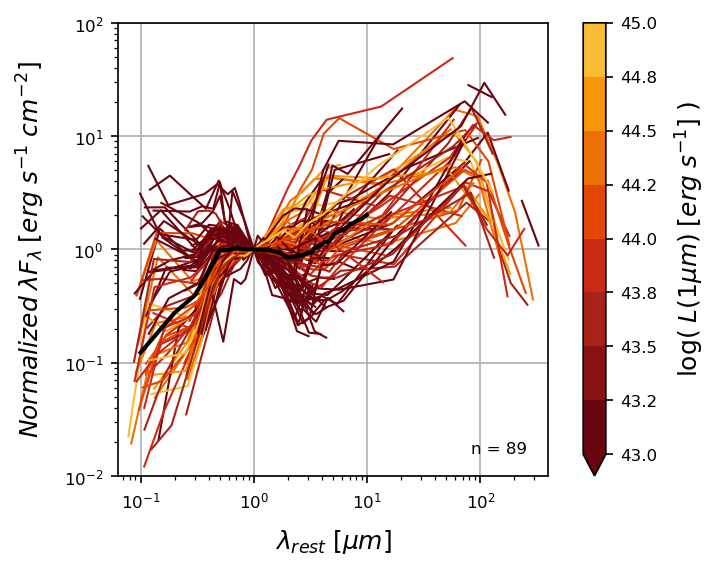

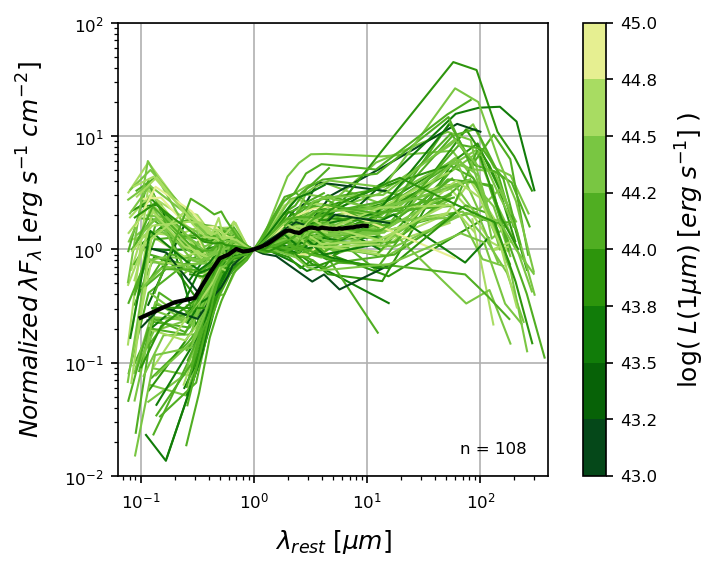

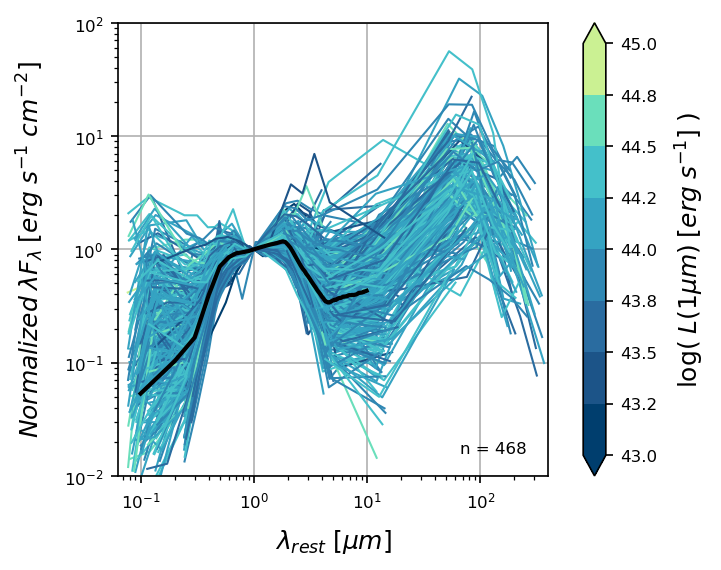

In [12]:
PlotSED_Row([agnInfo_byZ['$0 < z \leq 1$']['RED']['Rest Wavelength']],[agnInfo_byZ['$0 < z \leq 1$']['RED']['Energy Density Normalized at 1um']],[agnInfo_byZ['$0 < z \leq 1$']['RED']['Luminosity at 1um']],cmapKey=['r'],cbarRange=(43,45),cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',save=adp.path_fig+'\\v2_SED_red_z01_LumCbar.png',ymin=10**-2,ymax=10**2)
PlotSED_Row([agnInfo_byZ['$0 < z \leq 1$']['GRN']['Rest Wavelength']],[agnInfo_byZ['$0 < z \leq 1$']['GRN']['Energy Density Normalized at 1um']],[agnInfo_byZ['$0 < z \leq 1$']['GRN']['Luminosity at 1um']],cmapKey=['g'],cbarRange=(43,45),cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',save=adp.path_fig+'\\v2_SED_yel_z01_LumCbar.png',ymin=10**-2,ymax=10**2)
PlotSED_Row([agnInfo_byZ['$0 < z \leq 1$']['BLU']['Rest Wavelength']],[agnInfo_byZ['$0 < z \leq 1$']['BLU']['Energy Density Normalized at 1um']],[agnInfo_byZ['$0 < z \leq 1$']['BLU']['Luminosity at 1um']],cmapKey=['b'],cbarRange=(43,45),cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',save=adp.path_fig+'\\v2_SED_blu_z01_LumCbar.png',ymin=10**-2,ymax=10**2)

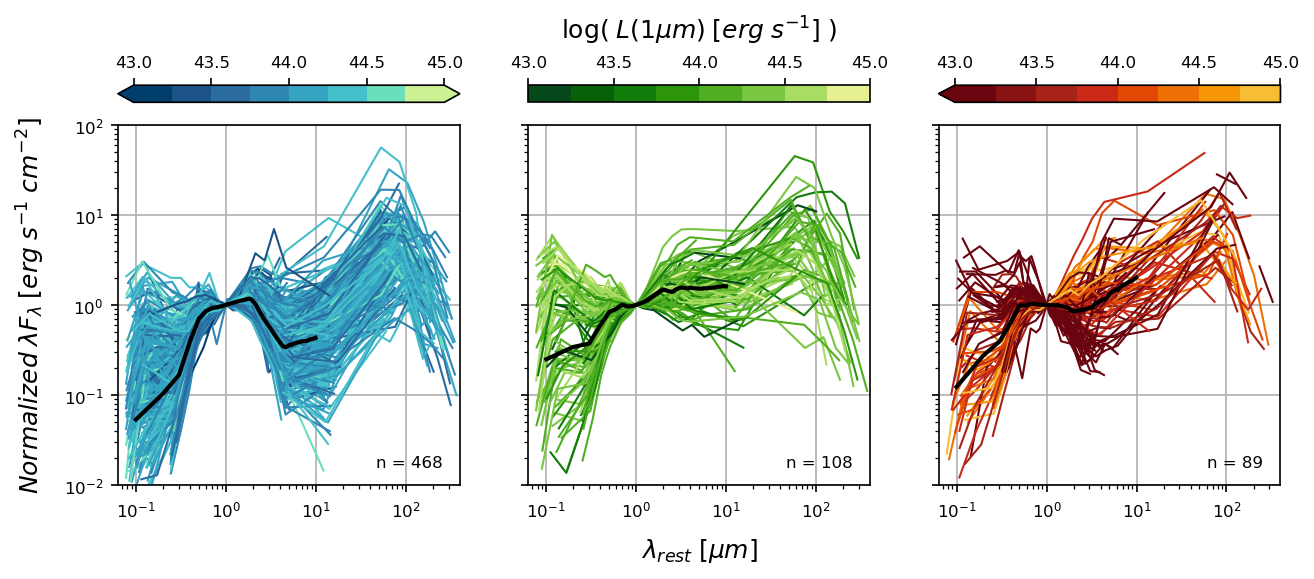

In [13]:
PlotSED_Row(
        x=[
                agnInfo_byZ['$0 < z \leq 1$']['BLU']['Rest Wavelength'],
                agnInfo_byZ['$0 < z \leq 1$']['GRN']['Rest Wavelength'],
                agnInfo_byZ['$0 < z \leq 1$']['RED']['Rest Wavelength']
        ],
        y=[     agnInfo_byZ['$0 < z \leq 1$']['BLU']['Energy Density Normalized at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['GRN']['Energy Density Normalized at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['RED']['Energy Density Normalized at 1um']
        ],            
        z=[     
                agnInfo_byZ['$0 < z \leq 1$']['BLU']['Luminosity at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['GRN']['Luminosity at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['RED']['Luminosity at 1um']
        ],
        cmapKey=['b','g','r'],      
        save=adp.path_fig+'\\v2_SED_3wide_z01_LumCbar.png',      
        orientWide=True,
        cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',
        cbarRange=(43,45),
        n_ticks=5,
        ymin=10**-2,
        ymax=10**2
)

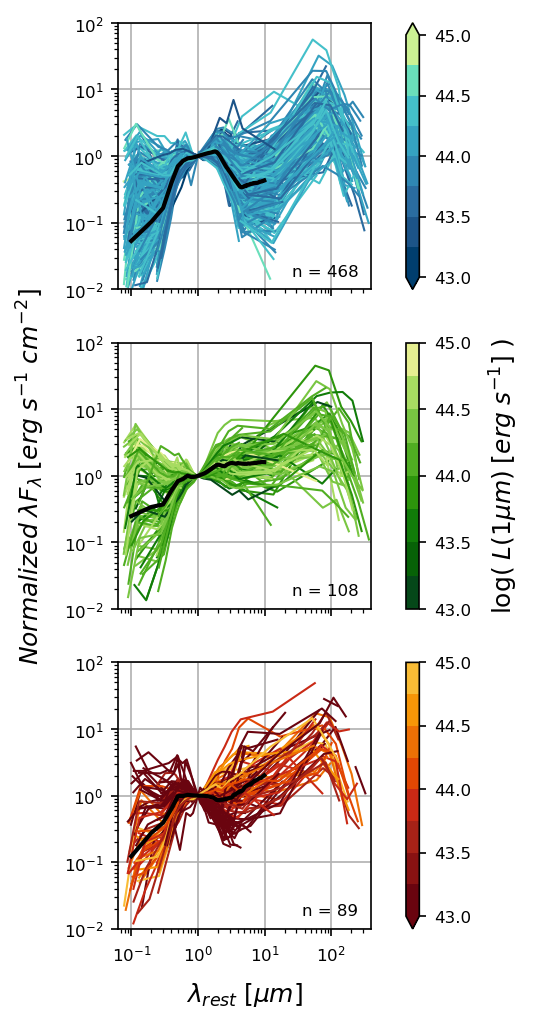

In [14]:
PlotSED_Row(
        x=[
                agnInfo_byZ['$0 < z \leq 1$']['BLU']['Rest Wavelength'],
                agnInfo_byZ['$0 < z \leq 1$']['GRN']['Rest Wavelength'],
                agnInfo_byZ['$0 < z \leq 1$']['RED']['Rest Wavelength']
        ],
        y=[     agnInfo_byZ['$0 < z \leq 1$']['BLU']['Energy Density Normalized at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['GRN']['Energy Density Normalized at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['RED']['Energy Density Normalized at 1um']
        ],            
        z=[     
                agnInfo_byZ['$0 < z \leq 1$']['BLU']['Luminosity at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['GRN']['Luminosity at 1um'],
                agnInfo_byZ['$0 < z \leq 1$']['RED']['Luminosity at 1um']
        ],
        cmapKey=['b','g','r'],      
        save=adp.path_fig+'\\v2_SED_3tall_z01_LumCbar.png',      
        orientWide=False,
        cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',
        cbarRange=(43,45),
        n_ticks=5,
        ymin=10**-2,
        ymax=10**2
)

# Luminosity histogram

In [15]:
def LogLum(lum) : 
    l = np.array(lum) # convert to array
    l = l[l>0] # exclude zeros
    l = np.log10(l) # get log of luminosity
    return(l)

In [16]:
def PlotHist_Lum1um_Triple_ax(
    ax,
    lum1_1um, lum2_1um, lum3_1um, # RED GRN BLU
    c1=adp.c_ir, c2=adp.c_ir_xray, c3=adp.c_xray,
    h=300, # plot height
    fullText='',
    showSum=True
):
    # get log
    lum1 = LogLum(lum1_1um)
    lum2 = LogLum(lum2_1um)
    lum3 = LogLum(lum3_1um)
    # plot histogram
    if(showSum):
        lum0 = np.concatenate((lum1,lum2,lum3))
        ax.hist(lum0,bins=np.arange(38,48,0.5), histtype='bar',  color='lightgray', linewidth=2)
    ax.hist(lum3,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c3,      linewidth=2)
    ax.hist(lum2,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c2,      linewidth=2)
    ax.hist(lum1,bins=np.arange(38,48,0.5), histtype='step', edgecolor=c1,      linewidth=2)
    # axis settings
    ax.set_xticks([38,39,40,41,42,43,44,45,46,47,48])
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_ylim(ymin=0, ymax=h)
    # adp.AddText_n_ax(ax,len(lum0), pre='$\mathrm{N_{total}}$ = ')
    adp.AddText_z_ax(ax, fullText)
    adp.MeanLineForHist_ax(ax,lum1,c=c1,xtext=0.99,ytext=0.94,pre='',horizAlign='right')
    adp.MeanLineForHist_ax(ax,lum2,c=c2,xtext=1.01,ytext=0.89,pre='',horizAlign='left')
    adp.MeanLineForHist_ax(ax,lum3,c=c3,xtext=1.01,ytext=0.84,pre='',horizAlign='left')

In [17]:
def PlotHist_Lum1um_Triple(agnInfo,save='',fullText='$0 < z \leq 6$',h=1000):
    adp.SetStyle() 
    fig, ax = plt.subplots(nrows=1,ncols=1,layout='constrained')
    PlotHist_Lum1um_Triple_ax( 
        ax, 
        agnInfo['RED']['Luminosity at 1um'], 
        agnInfo['GRN']['Luminosity at 1um'], 
        agnInfo['BLU']['Luminosity at 1um'],
        h=h,
        fullText=fullText
    )
    plt.xlabel('$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$')
    plt.ylabel('Number')
    # finish
    if(save) : adp.Save(save)
    plt.show()
    plt.close()


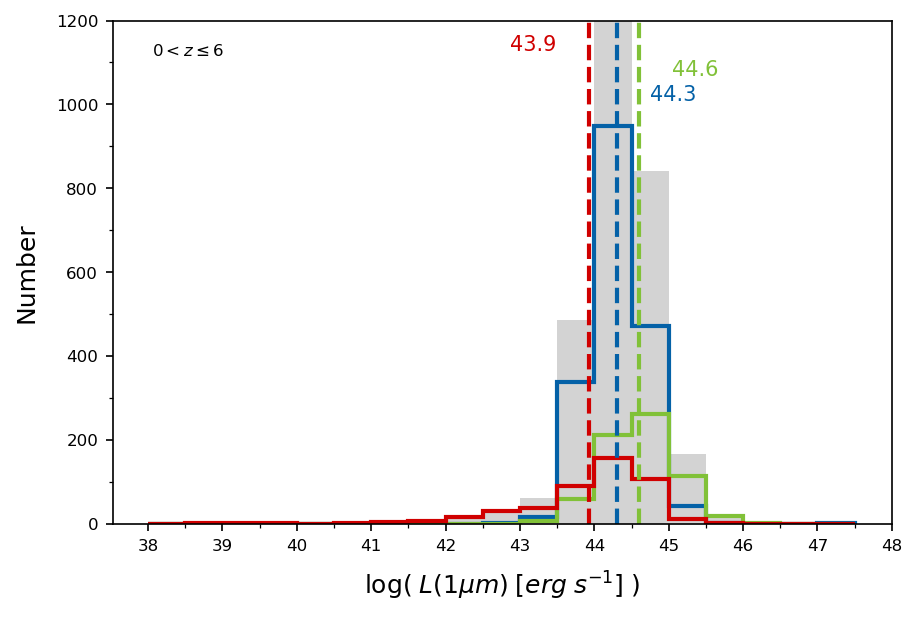

In [18]:
PlotHist_Lum1um_Triple(agnInfo,adp.path_fig + '\\v2_L1umHist_zAll.png',h=1200) 

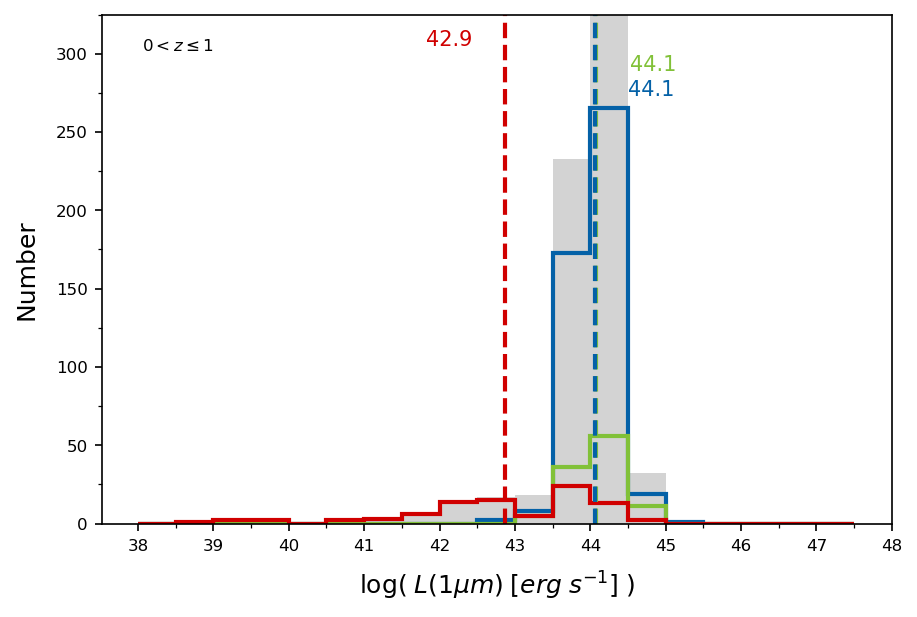

In [19]:
PlotHist_Lum1um_Triple(agnInfo_byZ['$0 < z \leq 1$'],adp.path_fig + '\\v2_L1umHist_z01.png', '$0 < z \leq 1$',325) 

In [20]:
def GetRanges(agnInfo) : 
    r = agnInfo['RED']['Luminosity at 1um'] 
    g = agnInfo['GRN']['Luminosity at 1um'] 
    b = agnInfo['BLU']['Luminosity at 1um']
    print('RED:\t', min(r), '-', max(r), 'erg/s \t(', np.average(r),'erg/s)')
    print('GRN:\t', min(g), '-', max(g), 'erg/s \t(', np.average(g),'erg/s)')
    print('BLU:\t', min(b), '-', max(b), 'erg/s \t(', np.average(b),'erg/s)')
    print('LOG RED:\t', min(LogLum(r)), '-', max(LogLum(r)), '\t(', (LogLum(r).mean()),')')
    print('LOG GRN:\t', min(LogLum(g)), '-', max(LogLum(g)), '\t(', (LogLum(g).mean()),')')
    print('LOG BLU:\t', min(LogLum(b)), '-', max(LogLum(b)), '\t(', (LogLum(b).mean()),')')

GetRanges(agnInfo_byZ['$0 < z \leq 1$'])

RED:	 7.713753711183049e+38 - 4.542112845937785e+44 erg/s 	( 4.934999786226752e+43 erg/s)
GRN:	 1.1470818154263432e+43 - 6.781141547885922e+44 erg/s 	( 1.5670870182535754e+44 erg/s)
BLU:	 4.4347505782904276e+42 - 1.1771120574594988e+45 erg/s 	( 1.3965516069769916e+44 erg/s)
LOG RED:	 38.88726576836698 - 44.65725791979109 	( 42.86236149289553 )
LOG GRN:	 43.0595943949902 - 44.83130280982815 	( 44.08065723173844 )
LOG BLU:	 42.64686919902271 - 45.07081780831482 	( 44.0602528229802 )


In [21]:
def PlotHist_Lum1um_Triple_byZ(
        agnInfo_byZ,
        save='',
        orientVertical=True
):
    if(orientVertical):
        figsizeConstVal=6
        xpos=(0.5, -0.01)
        ypos=(-0.05,  0.5)
    else:
        xpos=(0.5, -0.08)
        ypos=(-0.01,  0.5)
        figsizeConstVal=3

    fig, ax = adp.ByZ_SetupFig(
        n = len(agnInfo_byZ.keys()),
        orientVertical=orientVertical,
        figsizeConstVal=figsizeConstVal
    )
    
    # make plot for each redshift range
    i = 0
    for zrange, colorDict in agnInfo_byZ.items() :  
        PlotHist_Lum1um_Triple_ax( 
            ax[i], 
            colorDict['RED']['Luminosity at 1um'], 
            colorDict['GRN']['Luminosity at 1um'], 
            colorDict['BLU']['Luminosity at 1um'],
            fullText=zrange,
            h=400
        )
        # increment plot
        i+=1
    adp.ByZ_FinishPlot(
        fig,
        '$\log( \; L_{x(0.5-10keV)} \; [erg \; s^{-1}] \;)$',
        'Number',
        save, xpos, ypos
    )

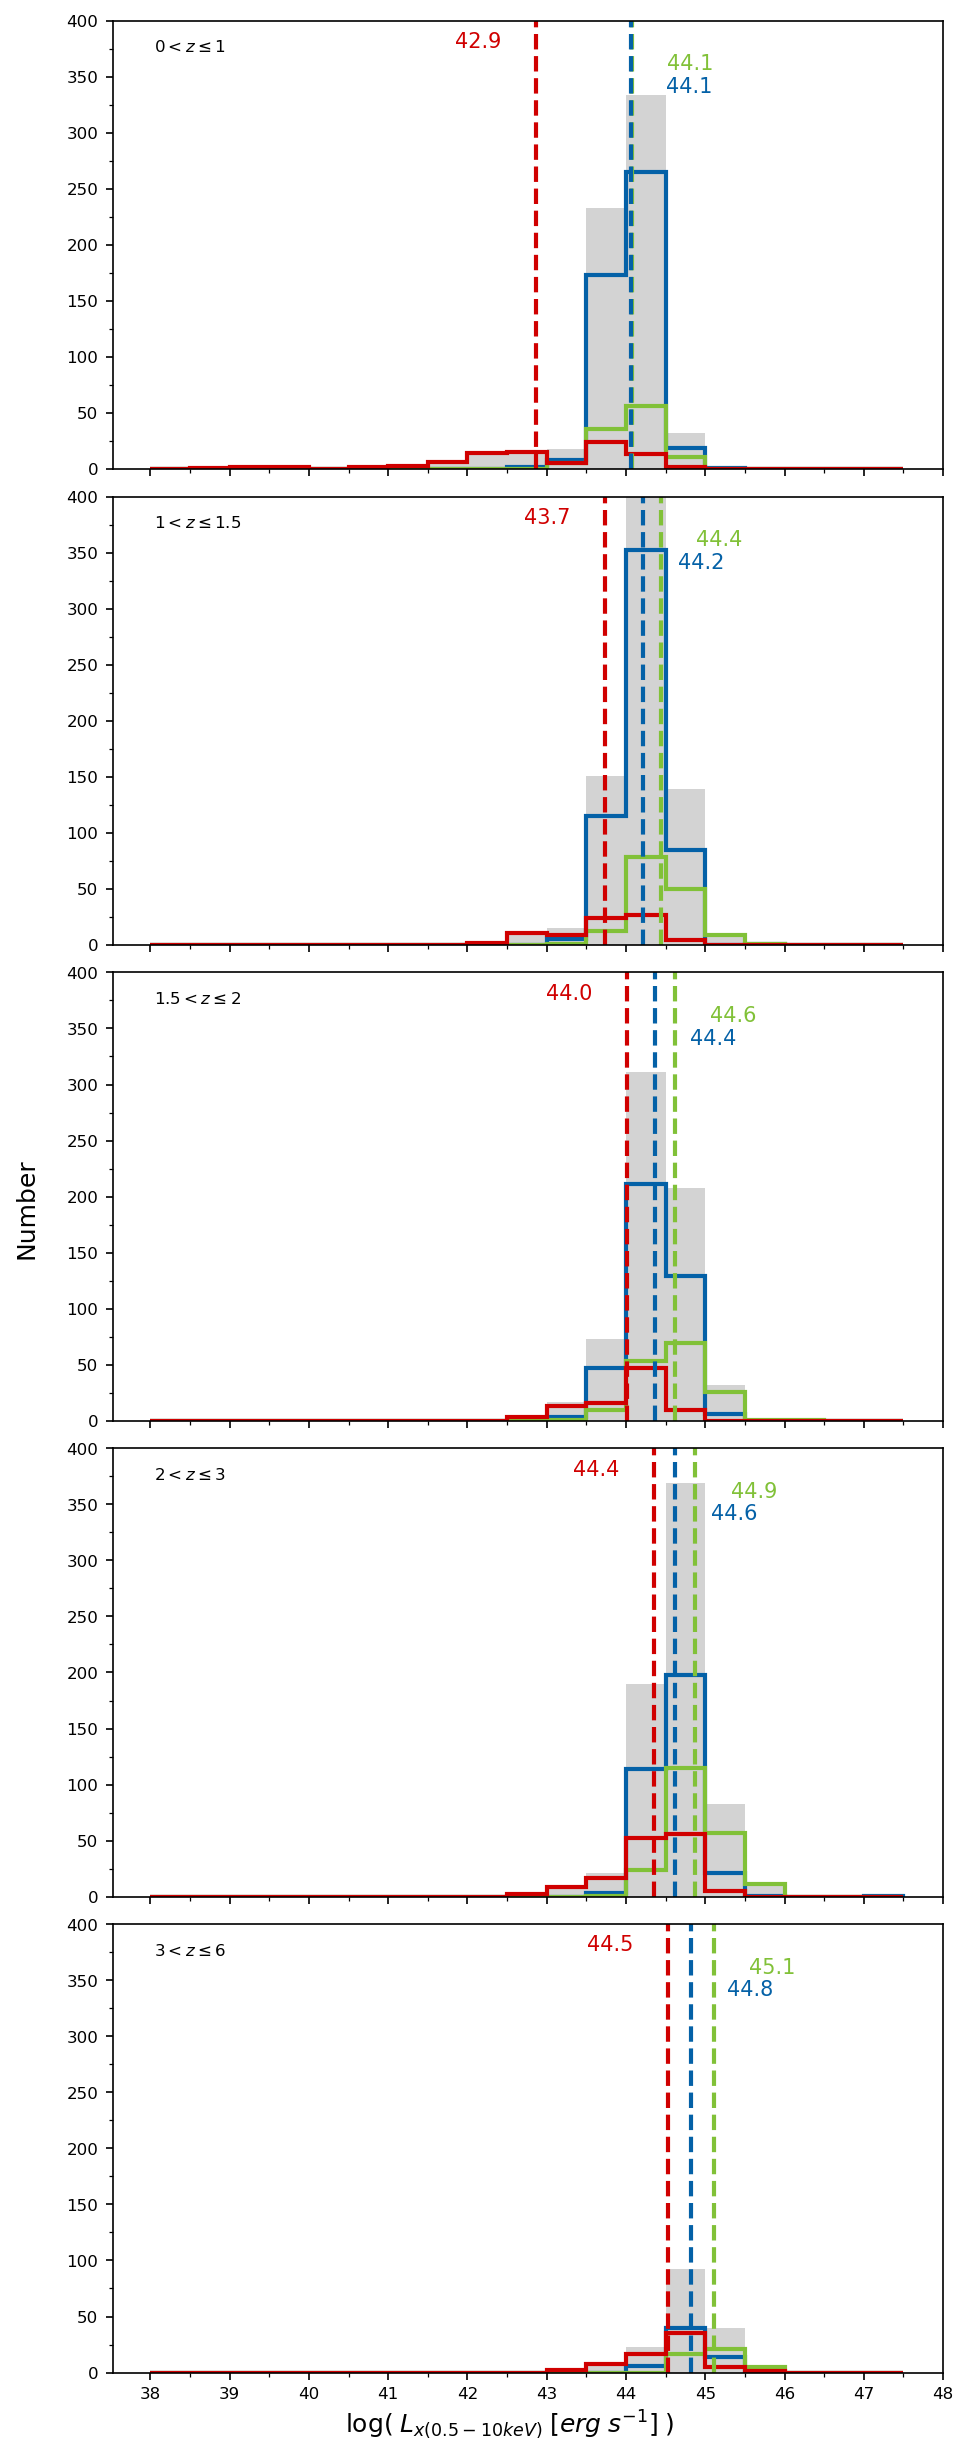

In [22]:
PlotHist_Lum1um_Triple_byZ(agnInfo_byZ, adp.path_fig + '\\v2_L1umHist_zPanel_tall.png',orientVertical=True)

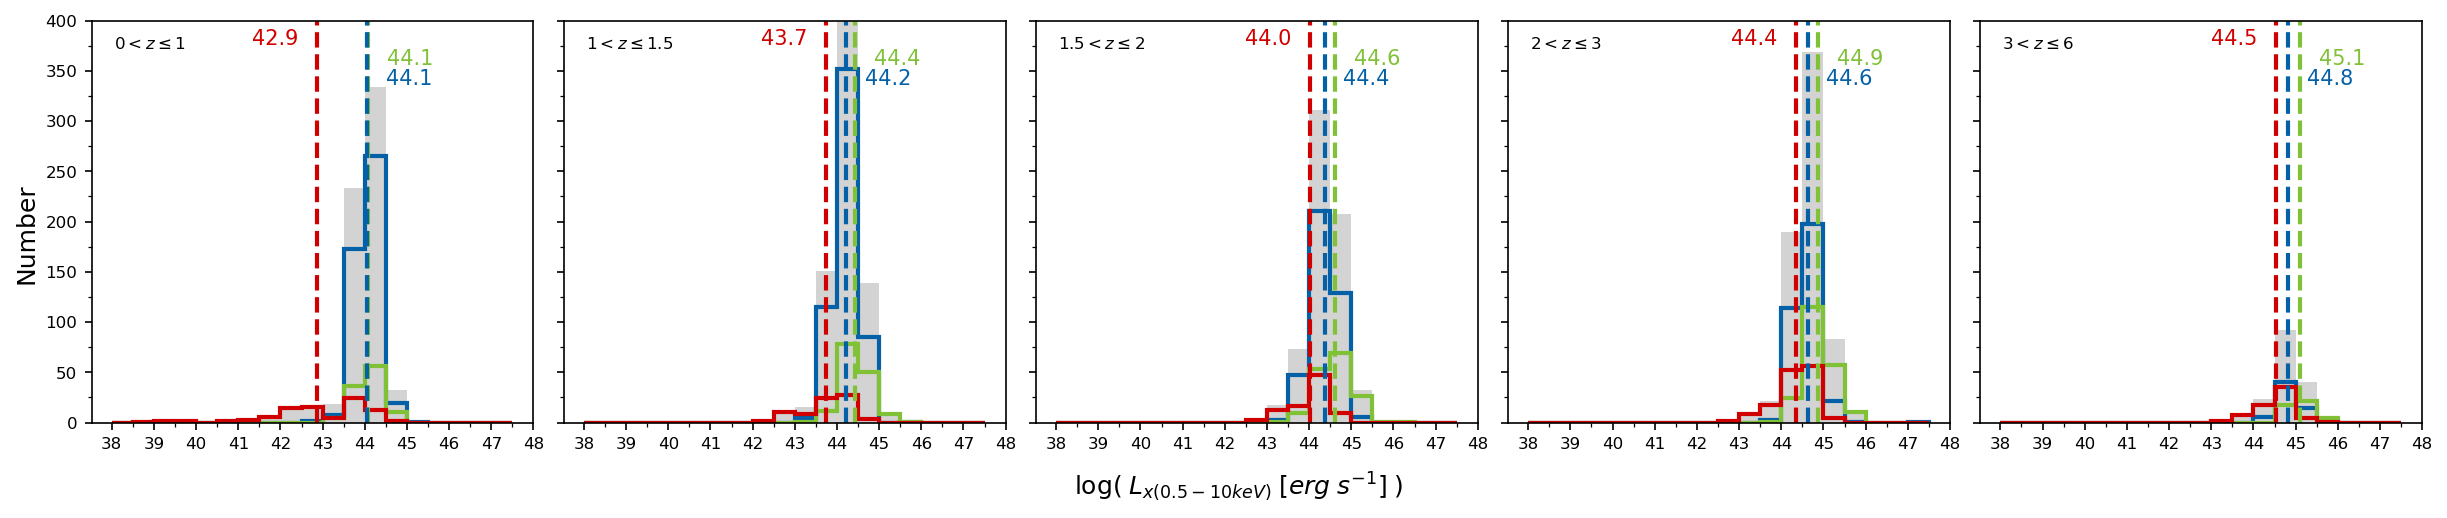

In [23]:
PlotHist_Lum1um_Triple_byZ(agnInfo_byZ, adp.path_fig + '\\v2_L1umHist_zPanel_wide.png',orientVertical=False)

# Investigate single object

In [24]:
def GetObjectFromID(id, mydict) : 
    for color,data in mydict.items() :
        # find index. IDs are unique, so the np.where array should return only one item
        i = np.where(data['ID'] == id)[0]
        if(len(i)==1) : return(color, int(i[0]))
    # no ID found
    return(None, None)

def PlotObjectFromID(id) : 
    c, i = GetObjectFromID(id, agnInfo_byZ['$0 < z \leq 1$'])
    print(c,i)
    if(i != None) : PlotSED_Row(
                x=[agnInfo_byZ['$0 < z \leq 1$'][c]['Rest Wavelength'][i] ],
                y=[agnInfo_byZ['$0 < z \leq 1$'][c]['Energy Density Normalized at 1um'][i] ],            
                z=[agnInfo_byZ['$0 < z \leq 1$'][c]['Luminosity at 1um'][i] ],
                cmapKey=[c ], orientWide=False, showBar=False, ymin=10**-2, ymax=10**2,
                title='ID: '+str(id) + ', L(1um)=' + str(round( np.log10(agnInfo_byZ['$0 < z \leq 1$'][c]['Luminosity at 1um'][i]), 2))     )
    else: print("No galaxy with ID", id)

In [25]:
# # plot 10 separatly
# i = 10 * 44
# data = agnInfo_byZ['$0 < z \leq 1$']['BLU']['ID']
# print(data[i])
# PlotObjectFromID(id=data[i+0])
# PlotObjectFromID(id=data[i+1])
# PlotObjectFromID(id=data[i+2])
# PlotObjectFromID(id=data[i+3])
# PlotObjectFromID(id=data[i+4])
# PlotObjectFromID(id=data[i+5])
# PlotObjectFromID(id=data[i+6])
# PlotObjectFromID(id=data[i+7])
# PlotObjectFromID(id=data[i+8])
# PlotObjectFromID(id=data[i+9])

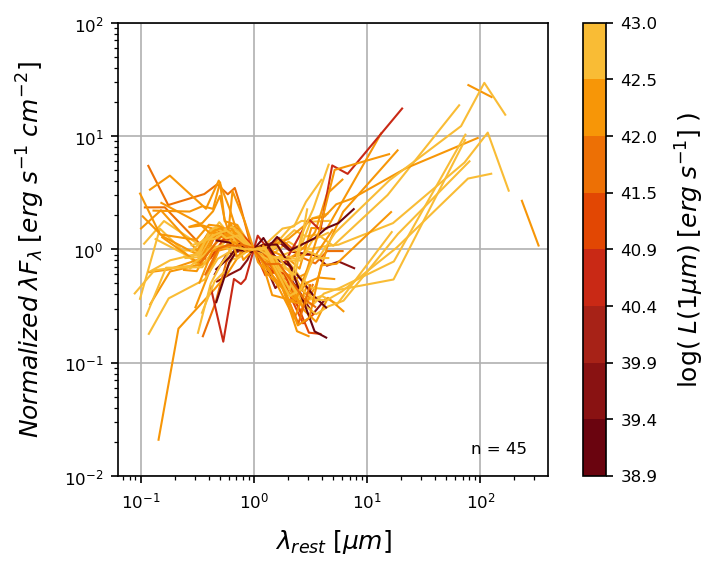

In [26]:
# plot L(1um) outlier SEDs
i_out = np.where( agnInfo_byZ['$0 < z \leq 1$']['RED']['Luminosity at 1um'] < 10**43.0 )[0]
PlotSED_Row(
        x=[ agnInfo_byZ['$0 < z \leq 1$']['RED']['Rest Wavelength'][i_out] ],
        y=[ agnInfo_byZ['$0 < z \leq 1$']['RED']['Energy Density Normalized at 1um'][i_out] ],            
        z=[ agnInfo_byZ['$0 < z \leq 1$']['RED']['Luminosity at 1um'][i_out] ],
        cmapKey=['r'],      
        save=adp.path_fig+'\\v2_SED_red_lowL1um_z01.png',      
        orientWide=False,
        cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',
        # cbarRange=(43,45),
        n_ticks=9,
        ymin=10**-2,
        ymax=10**2,
        median=False
)


# Check 

In [27]:
# get IRAC data (unit = 'uJy')
ch1_data20  = np.array(data20['SPLASH_CH1_FLUX']) # 3.5686 um
print('.', end='')
ch2_data20  = np.array(data20['SPLASH_CH2_FLUX']) # 4.5067 um
print('.', end='')
ch3_data20  = np.array(data20['SPLASH_CH3_FLUX']) # 5.7788 um
print('.', end='')
ch4_data20  = np.array(data20['SPLASH_CH4_FLUX']) # 7.9958 um 
print('.', end='')
# get ID
id_data20 = np.array(data20['ID_COSMOS2015'])
print('.', end='')

.....

In [28]:
def TriToIRACcolors(
    id_tricolorDict,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
):
    # match IDs to data20 
    key_id_red, key_red = match.match(id_catalog, id_tricolorDict['RED'])
    key_id_yel, key_yel = match.match(id_catalog, id_tricolorDict['GRN'])
    key_id_blu, key_blu = match.match(id_catalog, id_tricolorDict['BLU'])
    # calculate colors 
    xy_IRAC_tri = {
        'RED' : { 'x' : adp.IRACx(ch1[key_id_red], ch3[key_id_red]), 'y' : adp.IRACy(ch2[key_id_red], ch4[key_id_red])},
        'GRN' : { 'x' : adp.IRACx(ch1[key_id_yel], ch3[key_id_yel]), 'y' : adp.IRACy(ch2[key_id_yel], ch4[key_id_yel])},
        'BLU' : { 'x' : adp.IRACx(ch1[key_id_blu], ch3[key_id_blu]), 'y' : adp.IRACy(ch2[key_id_blu], ch4[key_id_blu])}
    }
    # return dictionary of IRAC colors by AGN group
    return(xy_IRAC_tri)

triID = {
    'RED' : agnInfo_byZ['$0 < z \leq 1$']['RED']['ID'],
    'GRN' : agnInfo_byZ['$0 < z \leq 1$']['GRN']['ID'],
    'BLU' : agnInfo_byZ['$0 < z \leq 1$']['BLU']['ID'],
}
# calculate colors of IRAC 
xy_IRAC_tri = TriToIRACcolors(
    triID,
    id_data20,
    ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)


In [29]:
# plot 3 types of AGN on Donley IRAC color-color plot
def PlotDonleyTricolor(
        x_xr, y_xr,             # X-ray (blue)
        x_ir, y_ir,             # infrared (red)
        x_ix, y_ix,             # overlap (yellow)
        path='',                # save
        fileName='',            # save
        saveNum=2,              # 2= nolegend, w/legend. 1=regular w/legend. 0=none
        printInfo=True          # output text
    ) :
    # standard plot style
    adp.SetStyle()

    # plot data
    plt.scatter(x_xr, y_xr, marker='s', c=adp.c_xray,     s=3, label='Exclusive X-ray (n='+str(len(x_xr))+')')
    plt.scatter(x_ir, y_ir, marker='^', c=adp.c_ir,       s=3, label='Exclusive MIR (n='+str(len(x_ir))+')')
    plt.scatter(x_ix, y_ix, marker='o', c=adp.c_ir_xray,  s=3, label='Inclusive (n='+str(len(x_ix))+')')

    # plotting class
    adp.PlotDonleyWedge()
    adp.AddText_n(len(x_ir)+len(x_xr)+len(x_ix), pre='$\mathrm{N_{total}}$ = ')

    # make plot square
    ax = plt.gca()
    ax.set_aspect('equal')
    ax.set_adjustable('box') 

    # tick marks
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # save
    if(path and fileName) :
        if(saveNum==2) : 
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            adp.Save(path+'\\'+fileName+'.png')
        if(saveNum>=1) :
            plt.axis([-0.7,1.0,-0.7,1.0]) 
            plt.legend(loc='upper left', markerscale=2, frameon=False)
            adp.Save(path+'\\'+fileName+'_legend.png')
    else :
        plt.axis([-0.7,1.0,-0.7,1.0]) 
        plt.legend(loc='upper left', markerscale=2, frameon=False) 

    # display
    plt.show()

    # print info 
    if(printInfo) :
        print( len(x_xr) / (len(x_xr)+len(x_ix)) * 100., '% of Xray-selected sources fall outside wedge or are not monotomically rising.')
        print( len(x_ir) / (len(x_ir)+len(x_ix)) * 100. ,'% of MIR-selected sources have no Xray greater than 10^43')

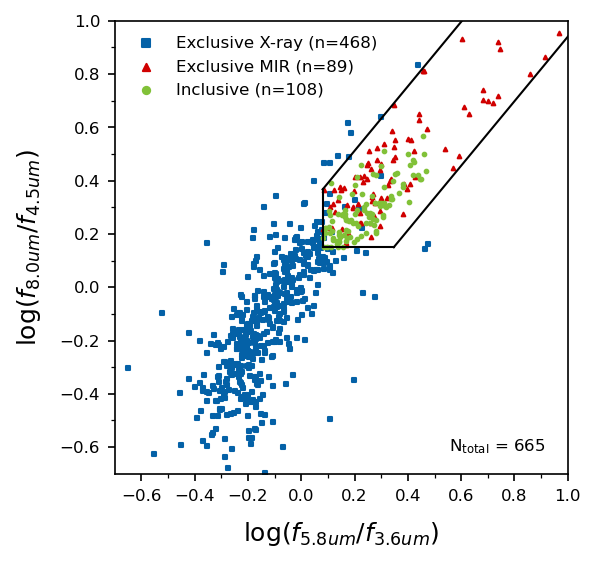

81.25 % of Xray-selected sources fall outside wedge or are not monotomically rising.
45.17766497461929 % of MIR-selected sources have no Xray greater than 10^43


In [30]:
PlotDonleyTricolor(
    xy_IRAC_tri['BLU']['x'], xy_IRAC_tri['BLU']['y'], 
    xy_IRAC_tri['RED']['x'], xy_IRAC_tri['RED']['y'], 
    xy_IRAC_tri['GRN']['x'], xy_IRAC_tri['GRN']['y'], 
    path=adp.path_fig, 
    saveNum=2,
    printInfo=True
)

# this plot should look exactly like v2_colorDiagram_tri_z01_legend
# As of 10/20/23 they seem to match 

In [31]:
def JustIRACs(
    id_tricolorDict,
    id_catalog,
    ch1,    # f_3.6um
    ch2,    # f_4.5 um
    ch3,    # f_5.6um
    ch4     # f_8.0um
) : 
    # match IDs to data20 
    key_id_red, key_red = match.match(id_catalog, id_tricolorDict['RED'])
    key_id_yel, key_yel = match.match(id_catalog, id_tricolorDict['GRN'])
    key_id_blu, key_blu = match.match(id_catalog, id_tricolorDict['BLU'])

    xy_IRAC_tri = {
        'RED' : { '1' : ch1[key_id_red] , 
                  '2' : ch2[key_id_red] ,
                  '3' : ch3[key_id_red] ,
                  '4' : ch4[key_id_red]},
    
        'GRN' : { '1' : ch1[key_id_yel] , 
                  '2' : ch2[key_id_yel] ,
                  '3' : ch3[key_id_yel] ,
                  '4' : ch4[key_id_yel]},

        'BLU' : { '1' : ch1[key_id_blu] , 
                  '2' : ch2[key_id_blu] ,
                  '3' : ch3[key_id_blu] ,
                  '4' : ch4[key_id_blu]}
    }
    # return dictionary of IRAC colors by AGN group
    return(xy_IRAC_tri)

IRAC_tri = JustIRACs(
    triID,
    id_data20,
    ch1_data20,ch2_data20,ch3_data20,ch4_data20 
)

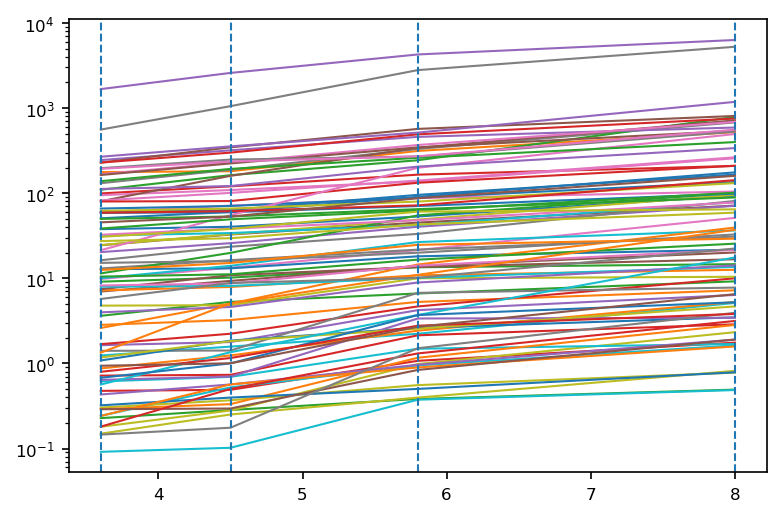

In [32]:
def PlotIRACsPhot(IRAC_one) :
    x = [3.6, 4.5, 5.8, 8.0]
    for i in range(len(IRAC_one['1'])) :
        y = [IRAC_one['1'][i], IRAC_one['2'][i], IRAC_one['3'][i], IRAC_one['4'][i]]
        plt.plot(x,y)
    for xi in x : plt.axvline(xi, linestyle='--')
    plt.yscale('log')

PlotIRACsPhot(IRAC_tri['RED'])

Number AGN with NaNs:  18 (20%)


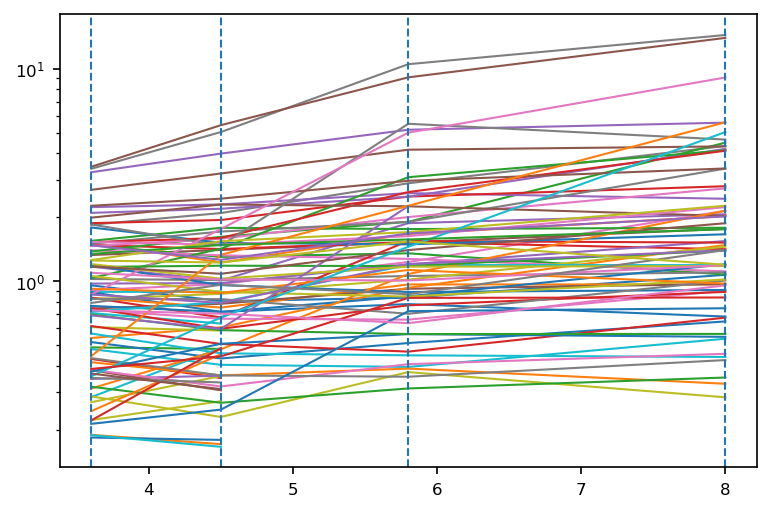

In [33]:
def PlotIRACsEnergy(IRAC_one) : 
    ch1 = 10
    ch2 = 11
    ch3 = 12
    ch4 = 13
    nanCount = 0
    x = [3.6, 4.5, 5.8, 8.0]
    for i in range(len(IRAC_one)) :
        y = [IRAC_one[i][ch1], IRAC_one[i][ch2], IRAC_one[i][ch3], IRAC_one[i][ch4]]
        plt.plot(x,y)
        if(True in np.isnan(y)) : nanCount+=1
    for xi in x : plt.axvline(xi, linestyle='--')
    plt.yscale('log')
    print('Number AGN with NaNs: ', nanCount, '('+str(int(100*nanCount/len(IRAC_one)))+'%)')

PlotIRACsEnergy(agnInfo_byZ['$0 < z \leq 1$']['RED']['Energy Density Normalized at 1um'])

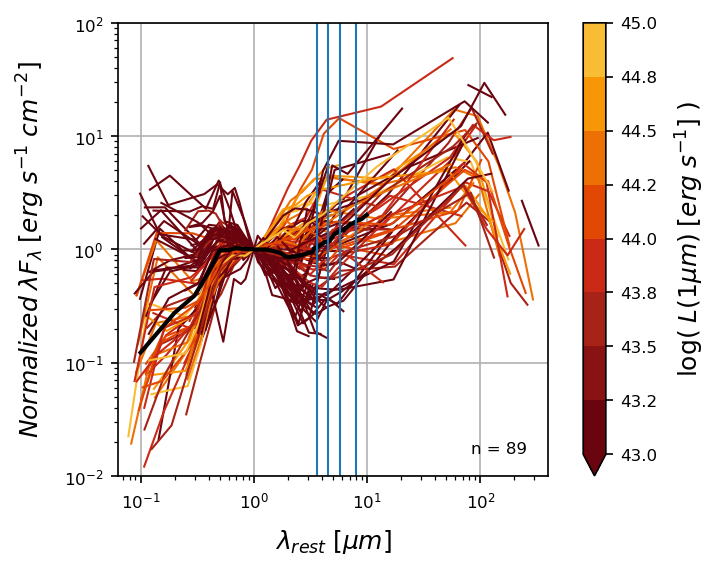

In [34]:
def PlotSED_Row_IRAC(
        x,                  # x-axis data LIST:   lam [A]
        y,                  # y-axis data LIST:  lamFlam [erg/s/cm2]
        z,                  # colorbar data LIST
        cmapKey,            # colormap options: red, grn, blu, (jet otherwise)
        n_ticks=9,          # number of ticks on colorbar
        showBar=True,       # show the colorbar 
        save='',            # filename to save
        median=True,        # plots a median line when true
        xmin=10**-1.2,      # plot range 
        xmax=10**2.6,       #   "    "
        ymin=10**-2.0,      #   "    "
        ymax=10**2.0,       #   "    "
        orientWide=False,   # true for tall, false for wide 
        cbarLabel='$Normalized \; \lambda F_{\lambda} \; at \; 24 \mu m$',
        cbarRange=None,      # tuple range of colorbar (min, max)
        title=None
):
    # check that lists are all same length 
    n = len(x)
    if(n!=len(y) and n!=len(z) and n!=len(cmapKey) ):
        print('[!] Bad inputs')
        return

    # determine subplot shape and parameters
    if(orientWide) :
        nrow = 1
        ncol = len(x)
        figsize = (4+(2*n), 4)
        cbarLocation = 'top'
    else:
        nrow = len(x)
        ncol = 1
        figsize = (6, 2+(2*n))
        cbarLocation = 'right'

    # build figure
    adp.SetStyle() 
    fig = plt.figure(figsize=figsize)    
    ax = []
    for i in range(n):
        ax.append(fig.add_subplot(nrow,ncol,i+1))
   
    # plot each SED
    for i in range(n): 
        # initialize plot settings 
        xTicks=True
        yTicks=True
        xLabel=False
        yLabel=False
        cbarLab=None
        # for wide plot 
        if(orientWide==1) : 
            if(i>0) :           
                yTicks = False
            if(i==int(n/2)):    
                xLabel = True 
                cbarLab = cbarLabel
            if(i==0) :          
                yLabel = True 
        # for tall plot 
        elif(orientWide==0) :
            if(i<n-1):          
                xTicks = False
            if(i==n-1):         
                xLabel = True 
            if(i==int(n/2)):    
                yLabel = True 
                cbarLab = cbarLabel

        # fix type
        if(isinstance(z[i], np.float64)) :
            zi = np.array([z[i]])
        else : 
            zi = z[i]
        # determine color range
        if(cbarRange):
            cbarMin=cbarRange[0]
            cbarMax=cbarRange[1]
            z_forMap = SED.PrepareCmapValues(zi,min=10**cbarMin,max=10**cbarMax)
        else : 
            z_forMap = SED.PrepareCmapValues(zi) 
            cbarMin=min(z_forMap[0])
            cbarMax=max(z_forMap[0])

        # get colormap 
        cmap_use = SED.GetCmap(cmapKey[i], n_ticks)

        # plot on axis 
        SED.PlotSED_ax(
            ax=ax[i],            
            x=x[i],             
            y=y[i],             
            z=z_forMap[1],             
            cmap=cmap_use,          
            median=median,   
            xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax,
            xTicks=xTicks,
            yTicks=yTicks,
            xLabel=xLabel,
            yLabel=yLabel
        )

        ############################
        ax[i].axvline(3.6)
        ax[i].axvline(4.5)
        ax[i].axvline(5.8)
        ax[i].axvline(8.0)

        # colorbar 
        if(showBar) : 
            extend='neither'
            if(cbarRange) : 
                # check bounds
                smaller = np.nanmin(zi) < 10**cbarMin
                bigger = np.nanmax(zi) > 10**cbarMax
                if(smaller and bigger) :    extend = 'both'
                elif(smaller) :             extend = 'min'
                elif(bigger) :              extend = 'max'

            SED.PlotColorbar_ax(
                ax=ax[i], 
                cmap=cmap_use, 
                min=cbarMin, 
                max=cbarMax, 
                n_ticks=n_ticks, 
                label=cbarLab, 
                location=cbarLocation,
                extend=extend
            )

    # set title of plot 
    if(title) :
        plt.title(title)

    # save plot as image 
    if(save) : 
        adp.Save(save)
    
    # finish
    plt.show()
    plt.close()


PlotSED_Row_IRAC([agnInfo_byZ['$0 < z \leq 1$']['RED']['Rest Wavelength']],[agnInfo_byZ['$0 < z \leq 1$']['RED']['Energy Density Normalized at 1um']],[agnInfo_byZ['$0 < z \leq 1$']['RED']['Luminosity at 1um']],cmapKey=['r'],cbarRange=(43,45),cbarLabel='$\log( \; L(1 \mu m) \; [erg \; s^{-1}] \;)$',ymin=10**-2,ymax=10**2)